## Hoori Javadnia


# ADS 509 Module 3: Group Comparison
The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics and Twitter descriptions for the two artists you selected in Module 1. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following:

Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set.
Calculate descriptive statistics on the two sets of lyrics and compare the results.
For each of the four corpora, find the words that are unique to that corpus.
Build word clouds for all four corpora.
Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization).

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 




Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [ ]:
#library neeeded

import os
import re
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

In [26]:
# Use this space for any additional import statements you need
from IPython.display import display_html
import warnings
from zipfile import ZipFile

warnings.filterwarnings("ignore")

In [27]:
# Stopwords
sw = stopwords.words("english")

# Some punctuation variations
punct = list(set(punctuation))
punct.append(",")
punct = "".join(punct)
tw_punct = list(set(punct) - set(["#"]))
tw_punct = "".join(tw_punct)

In [28]:
# Place any addtional functions or constants you need here. 
def display_side_by_side(*args):
    html_str = ''
    for df in args:
        html_str += df.to_html()
    display_html(
        html_str.replace('table', 'table style="display:inline"'), 
        raw = True
    )

# Convert lyric text file to dataframe
def txt_to_dict(artist):
    # Create list of files in artist's subdirectory
    song_list = os.listdir(lyrics_path + artist)
    # Create empty list to hold data
    lyrics_list = []
    # Read each file in the artist's folder
    for song in song_list:
        metadata = {}
        path_to_song = lyrics_path + artist + "/" + song
        with open(path_to_song, "r") as song_lyrics:
            lyrics = song_lyrics.read()
        metadata["Artist"] = artist
        metadata["Title"] = lyrics.split("\n", 2)[0]
        metadata["Lyrics"] = lyrics.split("\n", 2)[2]
        # Append metadata to lyrics_list
        lyrics_list.append(metadata)
    # Convert lyrics_list to dict
    lyrics_df = pd.DataFrame.from_records(lyrics_list)
    
    return lyrics_df

# Global text prep pipeline function
def prepare(text, pipeline): 
    tokens = str(text)

    for transform in pipeline: 
        tokens = transform(tokens)
        
    return(tokens)
    
# Remove Punctuation Function
def remove_punctuation(text): 
    text = text.translate(str.maketrans("", "", tw_punct))
    return text

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# Remove White Spaces Function
def remove_whitespace(text):
    text = whitespace_pattern.sub(r" ", text)
    return text

def tokenize(text):  
    tokens = text.split(" ")
    # Remove empty splits
    tokens = [x for x in tokens if x != ""]
    return tokens

def remove_stop(tokens):
    tokens = [x for x in tokens if not x in sw]
    return tokens


# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.EMOJI_DATA : 
    for em in emoji.EMOJI_DATA[country] : 
        all_language_emojis.add(em)

def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch) == True]

    return [len(emojis) > 0, emojis]

def descriptive_stats(df_col, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity, and num_tokens most common
        tokens. Return a list of 
    """
    # Initialize blank counter
    token_counter = Counter()
    # Update counter row by row with token column
    df_col.map(token_counter.update)
    
    num_tokens = sum(token_counter.values())
    num_unique_tokens = len(token_counter)
    lexical_diversity = num_unique_tokens / num_tokens

    num_characters = 0
    for k,v in token_counter.items():
        token_length = len(k) * v
        num_characters += token_length

    top_tokens = token_counter.most_common(5)
    # Convert top 5 tokens to dataframe
    top_token_df = pd.DataFrame(top_tokens, columns = ["Token", "Frequency"])
    
    if verbose == True:        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the five most common tokens
        print("The top five most common tokens are:")
        print(top_token_df)
        
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])

## Data Ingestion
Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [29]:
# Read in the Lyrics and Twitter data
# Location of zip file
zip_folder = ("/Users/javadniahoori/Downloads/509/3/assignment/M1 Assignment Data.zip")

# Open zip file contents
with ZipFile (zip_folder, "r") as zipfile:
    zip_contents = zipfile.namelist()

    # Read zip file contents
    for f in zip_contents:
        # Look for twitter data
        if f.startswith("M1 Results/"):
            # Extract text files from twitter data
            if f.endswith(".txt"):
                zipfile.extract(f)

In [30]:
# Lyrics and Twitter Ingestion
data_location = ("M1 Results/")

lyrics_folder = "lyrics/"
# Read in the lyrics data
lyrics_path = (data_location + lyrics_folder)

# Ingest lyrics to dataframe
# Columns: Artist, Title, Lyrics
cher_lyrics = txt_to_dict("cher")
robyn_lyrics = txt_to_dict("robyn")

In [31]:
# Read in Cher Tweet Information
cher_tweet_df = pd.read_table("M1 Results/twitter/cher_followers_data.txt",
                   delimiter = "\t",
                   # Skips 17/3,000,000+ lines
                   on_bad_lines = "skip")

# Read in Robyn Tweet Information
robyn_tweet_df = pd.read_table(
    "M1 Results/twitter/robynkonichiwa_followers_data.txt",
    delimiter = "\t")

## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove stopwords (optional)
* Remove punctuation
* Split on whitespace

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you. Note that we remove stopwords before removing punctuation because the stopword set includes punctuation.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove stopwords
* Remove punctuation other than emojis or hashtags
* Split on whitespace

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

In [32]:
# Apply Processing Pipeline
prep_pipeline = [str.lower, remove_punctuation, 
                   remove_whitespace, tokenize, 
                   remove_stop]

cher_lyrics["tokens"] = cher_lyrics["Lyrics"].apply(
    prepare, pipeline = prep_pipeline
)
cher_lyrics["num_tokens"] = cher_lyrics["tokens"].map(len)

robyn_lyrics["tokens"] = robyn_lyrics["Lyrics"].apply(
    prepare, pipeline = prep_pipeline
)
robyn_lyrics["num_tokens"] = robyn_lyrics["tokens"].map(len)

In [33]:
# 1. Remove rows with missing values in description
#cher_tweet_df = cher_tweet_df.dropna(subset = "description")
#robyn_tweet_df = robyn_tweet_df.dropna(subset = "description")

# 2. Apply Processing Pipeline
cher_tweet_df["tokens"] = cher_tweet_df["description"].apply(
    prepare, pipeline = prep_pipeline
)
cher_tweet_df["num_tokens"] = cher_tweet_df["tokens"].map(len)

robyn_tweet_df["tokens"] = robyn_tweet_df["description"].apply(
    prepare, pipeline = prep_pipeline
)
robyn_tweet_df["num_tokens"] = robyn_tweet_df["tokens"].map(len)

In [34]:
cher_tweet_df["has_emoji"] = cher_tweet_df["description"].apply(
    lambda x: contains_emoji(x)[0])
cher_tweet_df["emojis"] = cher_tweet_df["description"].apply(
    lambda x: contains_emoji(x)[1])

robyn_tweet_df["has_emoji"] = robyn_tweet_df["description"].apply(
    lambda x: contains_emoji(x)[0])
robyn_tweet_df["emojis"] = robyn_tweet_df["description"].apply(
    lambda x: contains_emoji(x)[1])

In [35]:
print("Cher Tweet Description and Emoji Tokens")
cher_tweet_df[cher_tweet_df["has_emoji"] == True].sample(10)[["description", "tokens"]]

Cher Tweet Description and Emoji Tokens


,description,tokens
1877890,writer. formerly social/digital for @padmalaks...,"[writer, formerly, socialdigital, padmalakshmi..."
425198,Download: https://t.co/GdwlSe9Mnp SoundForest ...,"[download, httpstcogdwlse9mnp, soundforest, mi..."
773190,Peds Nurse 👶: I help save little people's live...,"[peds, nurse, 👶, help, save, little, peoples, ..."
3211575,Philadelphia Eagles Fan 💚💚 #jerseygirl,"[philadelphia, eagles, fan, 💚💚, #jerseygirl]"
262582,Void where prohibited Restrictions may Apply ~...,"[void, prohibited, restrictions, may, apply, m..."
2521399,🧚‍♂️+🍩+☀️,[🧚‍♂️🍩☀️]
1223481,"19, they/them, ♒, artist & anarchist https://t...","[19, theythem, ♒, artist, anarchist, httpstco1..."
890938,Basically an Ari stan account 🕺🥸,"[basically, ari, stan, account, 🕺🥸]"
1528839,"Half assin’ it since 1985. Book, music, movie ...","[half, assin’, since, 1985, book, music, movie..."
29923,"God, Jesus, & family always ❤️📖🕊Mother of 2 ki...","[god, jesus, family, always, ❤️📖🕊mother, 2, ki..."


In [36]:
print("Robyn Tweet Description and Emoji Tokens")
robyn_tweet_df[robyn_tweet_df["has_emoji"] == True].sample(10)[["description", "tokens"]]

Robyn Tweet Description and Emoji Tokens


,description,tokens
23942,🔲👱🏼‍♂️laser👐 Personal account for @frankiedelt...,"[🔲👱🏼‍♂️laser👐, personal, account, frankiedelta..."
31387,Student🏫 official account🔥 At Instagram: raj_k...,"[student🏫, official, account🔥, instagram, rajk..."
30881,"🌹⛓DIVINELY EROTIC⛓🌹 AUTHOR: INNER WITCH, BEWIT...","[🌹⛓divinely, erotic⛓🌹, author, inner, witch, b..."
329565,☮️,[☮️]
58382,🏳️‍🌈 owl enthusiast. relentless nerd. jeremy b...,"[🏳️‍🌈, owl, enthusiast, relentless, nerd, jere..."
20,Cuenta alternativa 😊✌️🌈,"[cuenta, alternativa, 😊✌️🌈]"
51141,BON VOYAGE out now🚕💨,"[bon, voyage, now🚕💨]"
193419,highly intuitive • full time dreamer✨ ♋️🧘🏻‍♀️🌙,"[highly, intuitive, •, full, time, dreamer✨, ♋..."
301837,Texas Native🌮 Disney Obsessed🏰 Ariel 🧜🏼‍♀️ Tia...,"[texas, native🌮, disney, obsessed🏰, ariel, 🧜🏼‍..."
1368,✨Design/Arts/Humour/Drag/Hollywood/Foodie/I li...,"[✨designartshumourdraghollywoodfoodiei, like, ..."


With the data processed, we can now start work on the assignment questions. 

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: ### handling slashes as separate words, better stop word removal, and incorporating a spellchecker for user-generated content.
Alao Stemming tokens reduces complexity by reducing diversity and features in trained models.



## Calculate descriptive statistics on the two sets of lyrics and compare the results. 


In [37]:
print("Cher Lyrics - Descriptive Stats:\n")
print(descriptive_stats(cher_lyrics["tokens"]))

print("\nRobyn Lyrics - Descriptive Stats:\n")
print(descriptive_stats(robyn_lyrics["tokens"]))

Cher Lyrics - Descriptive Stats:

There are 35233 tokens in the data.
There are 3684 unique tokens in the data.
There are 169244 characters in the data.
The lexical diversity is 0.105 in the data.
The top five most common tokens are:
   Token  Frequency
0   love        966
1     im        511
2   know        480
3   dont        430
4  youre        332
[35233, 3684, 0.10456106491073709, 169244]

Robyn Lyrics - Descriptive Stats:

There are 15041 tokens in the data.
There are 2139 unique tokens in the data.
There are 72804 characters in the data.
The lexical diversity is 0.142 in the data.
The top five most common tokens are:
  Token  Frequency
0  know        305
1    im        299
2  dont        297
3  love        269
4   got        249
[15041, 2139, 0.1422112891430091, 72804]


In [38]:
print("Cher Words per Song:", round(35233/316, 4))
print("Years & Years Words per Song:",round(15041/104, 4))

Cher Words per Song: 111.4968
Years & Years Words per Song: 144.625


Q: what observations do you make about these data? 

A:Robyn has lexical_diversity higher than cher but Cher has more tokens than Robyn


## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it. 

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing. 

In this section find 10 tokens for each of your four corpora that meet the following criteria: 

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

In [39]:
# Count Frequency of Tokens Function
def token_counter(df_token_col):
    counter = Counter()
    df_token_col.map(counter.update)

    return counter

def unique_token(df_token1, df_token2,
                 n_threhold = 5):
    # 1. Count all token frequencies
    token_freq1 = token_counter(df_token1)
    token_freq2 = token_counter(df_token2)
    
    # 2. Total Number of Tokens in Corpora 
    total_token1 = sum(token_freq1.values())
    total_token2 = sum(token_freq2.values())
    
    # 3. Remove those with a frequency less than n
    filter_tokens1 = Counter(
        {key: count for key, 
         count in token_freq1.items() if count > n_threhold})
    filter_tokens2 = Counter(
        {key: count for key, 
         count in token_freq2.items() if count > n_threhold})
    
    # 4. Calculate Concentration Ratio within corpora
    # (token frequency/total number of tokens in corpora)
    for key, value in filter_tokens1.items():
        filter_tokens1[key] /= total_token1
    for key, value in filter_tokens2.items():
        filter_tokens2[key] /= total_token2
    
    # 5. Find keys that appear in all corpora
    common_keys = [k for k in filter_tokens1.keys() if k in filter_tokens2.keys()]

    # 6. Ratio between concentrations of common words
    df_list = []
    for word in common_keys:
        ratio1_2 = filter_tokens1[word] / filter_tokens2[word]
       
        word_ratio_list = [word, ratio1_2]
        df_list.append(word_ratio_list)
    
    # 7. Resulting Dataframe
    result_df = pd.DataFrame(
        df_list, columns = [
            "Token", "Ratio to Corpora 2"
        ]
    )
    
    return result_df

In [40]:
# Cher Lyrics Corpora Against Robyn Lyrics Corpora
cher_to_robyn = unique_token(
    cher_lyrics["tokens"], robyn_lyrics["tokens"], 
    n_threhold = 10)

cher_to_robyn_lyrics = cher_to_robyn[[
    "Token", "Ratio to Corpora 2"]].sort_values(
    by = "Ratio to Corpora 2", ascending = False)[:10]
cher_to_robyn_lyrics.columns = ["Cher Lyrics Token", "Ratio to Robyn Lyrics"]

# Robyn Lyrics Against Cher Lyrics
robyn_to_cher = unique_token(
    robyn_lyrics["tokens"], cher_lyrics["tokens"], 
    n_threhold = 10)

robyn_to_cher_lyrics = robyn_to_cher[[
    "Token", "Ratio to Corpora 2"]].sort_values(
    by = "Ratio to Corpora 2", ascending = False)[:10]
robyn_to_cher_lyrics.columns = ["Robyn Lyrics Token", "Ratio to Cher Lyrics"]

display_side_by_side(cher_to_robyn_lyrics, robyn_to_cher_lyrics)

,Cher Lyrics Token,Ratio to Robyn Lyrics
54,man,7.150590
89,believe,5.394475
86,well,4.349053
164,home,3.958536
106,night,3.298780
51,hes,2.910688
88,kiss,2.600215
18,see,2.306763
30,way,2.225983
134,hold,2.214549


In [41]:
# Cher Twitter Corpora Against Robyn Twitter Corpora
cher_tweet_to_robyn = unique_token(
    cher_tweet_df["tokens"], robyn_tweet_df["tokens"],
     n_threhold = 2)

cher_tweet_to_robyn_df = cher_tweet_to_robyn[[
    "Token", "Ratio to Corpora 2"]].sort_values(
    by = "Ratio to Corpora 2", ascending = False)[:10]
cher_tweet_to_robyn_df.columns = ["Cher Twitter Token", "Ratio to Robyn Twitter"]

# Robyn Twitter Corpora Against Cher Twitter Corpora
robyn_tweet_to_cher = unique_token(
    robyn_tweet_df["tokens"], cher_tweet_df["tokens"],
     n_threhold = 2)

robyn_tweet_to_cher_df = robyn_tweet_to_cher[[
    "Token", "Ratio to Corpora 2"]].sort_values(
    by = "Ratio to Corpora 2", ascending = False)[:10]
robyn_tweet_to_cher_df.columns = ["Robyn Twitter Token", "Ratio to Cher Twitter"]


display_side_by_side(cher_tweet_to_robyn_df,
                     robyn_tweet_to_cher_df)

,Cher Twitter Token,Ratio to Robyn Twitter
320,grandmother,35.281350
913,#fbr,24.528856
702,resister,24.391110
823,#resister,23.987951
759,nana,21.092673
18374,rbsoul,20.534224
270,grandma,19.139966
24,#theresistance,18.866994
16205,hiphoprap,17.938501
3360,gop,17.295514


Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

A:
Robyn's unique words like "beat" and "dance" convey the energetic tempo of her songs.
In the Twitter data, Cher's fans show interest in "rbsoul" and "hiphoprap," while all of Robyn's unique words are in a non-English language, reflecting her Swedish fanbase.



## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


In [42]:
from matplotlib import pyplot as plt

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    
    
    
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    
    
    print('--------------------------------------------------------------')
    
    wc.generate_from_frequencies(counter)
    print('111')
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

--------------------------------------------------------------
111


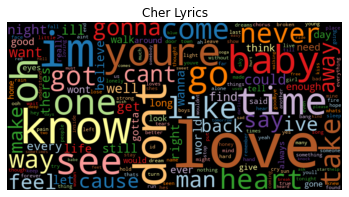

In [43]:

# Cher Lyrics Word Cloud
cher_word_cloud = count_words(cher_lyrics)
# Squeeze - to convert dataframe to Series
wordcloud(cher_word_cloud.squeeze(),title = "Cher Lyrics")

--------------------------------------------------------------
111


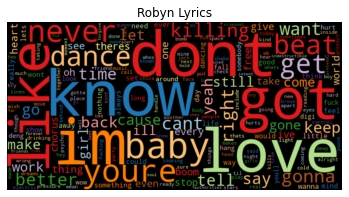

In [44]:
# Robyn Lyrics Word Cloud
robyn_word_cloud = count_words(robyn_lyrics)
# Squeeze - to convert dataframe to Series
wordcloud(robyn_word_cloud.squeeze(),
          title = "Robyn Lyrics")

--------------------------------------------------------------
111


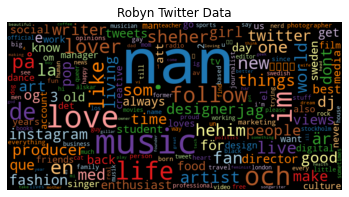

In [45]:
# Robyn Word Cloud
robyn_word_cloud = count_words(robyn_tweet_df)
# Squeeze - to convert dataframe to Series
wordcloud(robyn_word_cloud.squeeze(),
          title = "Robyn Twitter Data")

--------------------------------------------------------------
111


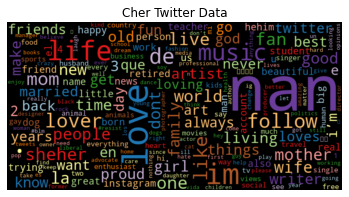

In [46]:
# Cher Word Cloud
cher_word_cloud = count_words(cher_tweet_df)
# Squeeze - to convert dataframe to Series
wordcloud(cher_word_cloud.squeeze(),
          title = "Cher Twitter Data")

Q: What observations do you have about these (relatively straightforward) wordclouds? 

A: Both individuals have "love" and "life" and "music" as the main topics represented in their respective word clouds.